In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch

In [22]:
torch.cuda.is_available()


True

In [23]:
import os, time, pickle, argparse, pix2pixNetwork, util
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.autograd import Variable
from skimage import io
from cv2 import hconcat

In [24]:
# data processing scripts 
sources = os.listdir("data/source/")
normals = os.listdir("data/normal/")
sources.sort()
normals.sort()


for i in range(0, len(normals)):
    curNormalPath = os.path.join("data/normal/", normals[i])
    curSourcePath = os.path.join("data/source/", sources[i])
    curNormal = io.imread(curNormalPath)
    curSource = io.imread(curSourcePath)
    print(curNormal.shape)
    print(curSource.shape)
    completeImg = hconcat([curSource, curNormal])
    io.imsave(os.path.join("data/completeData/", normals[i]), completeImg)

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1

In [25]:
# Showing data collection
img1 = io.imread("data/completeData/train/1.png")
img2 = io.imread("data/completeData/train/3.png")
img3 = io.imread("data/completeData/train/5.png")
img4 = io.imread("data/completeData/train/11.png")
img5 = io.imread("data/completeData/train/23.png")
img6 = io.imread("data/completeData/train/30.png")


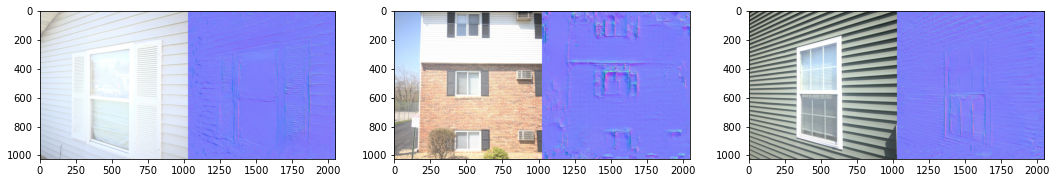

In [26]:

values = [1, 10, 100]
plt.figure(figsize=(18, 3))

plt.subplot(131)
plt.imshow(img1)
plt.subplot(132)
plt.imshow(img2)
plt.subplot(133)
plt.imshow(img3)  

In [7]:
# define parameters  
dataset = "source"
batch_size = 1
test_batch_size = 1
input_size = 256
crop_size = 256
resize_scale = 286
ngf = 64
ndf = 64
train_subfolder = "train"
test_subfolder = "test"
train_epoch = 200
lrDis = 0.0002
lrGen = 0.0002
L1_lambda = 100
beta1 = 0.5
beta2 = 0.999
save_root = "results"
inverse_order = False
fliplr = False

# results save path
root = dataset + '_' + save_root + '/'
model = dataset + '_'
if not os.path.isdir(root):
    os.mkdir(root)
if not os.path.isdir(root + 'Fixed_results'):
    os.mkdir(root + 'Fixed_results')

# data_loader
# add data augmentation 
# because only 70 pairs of data are available for this project
# so, data augmentation is important in this step. 
transform = transforms.Compose([
        # new added
        transforms.RandomHorizontalFlip(),
        # new added end, delete it if bug exists 
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

train_loader = util.data_load('data/completeData/', train_subfolder, transform, batch_size, shuffle=True)
test_loader = util.data_load('data/completeData/', test_subfolder, transform, test_batch_size, shuffle=True)
test = test_loader.__iter__().__next__()[0]

img_size = test.size()[2]
if inverse_order:
    fixed_y_ = test[:, :, :, 0:img_size]
    fixed_x_ = test[:, :, :, img_size:]
else:
    fixed_x_ = test[:, :, :, 0:img_size]
    fixed_y_ = test[:, :, :, img_size:]

if img_size != input_size:
    fixed_x_ = util.imgs_resize(fixed_x_, input_size)
    fixed_y_ = util.imgs_resize(fixed_y_, input_size)

In [21]:

G_losses = []
D_losses = []

# network
G = pix2pixNetwork.generator(ngf)
D = pix2pixNetwork.discriminator(ndf)
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)
G.cuda()
D.cuda()
G.train()
D.train()

# loss
BCE_loss = nn.BCELoss().cuda()
L1_loss = nn.L1Loss().cuda()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lrGen, betas=(beta1, beta2))
D_optimizer = optim.Adam(D.parameters(), lr=lrDis, betas=(beta1, beta2))

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []

print('training start!')
start_time = time.time()
for epoch in range(train_epoch):
    D_losses = []
    G_losses = []
    epoch_start_time = time.time()
    num_iter = 0
    for x_, _ in train_loader:
        # train discriminator D
        D.zero_grad()

        if inverse_order:
            y_ = x_[:, :, :, 0:img_size]
            x_ = x_[:, :, :, img_size:]
        else:
            y_ = x_[:, :, :, img_size:]
            x_ = x_[:, :, :, 0:img_size]
            
        if img_size != input_size:
            x_ = util.imgs_resize(x_, input_size)
            y_ = util.imgs_resize(y_, input_size)

        if resize_scale:
            x_ = util.imgs_resize(x_, resize_scale)
            y_ = util.imgs_resize(y_, resize_scale)

        if crop_size:
            x_, y_ = util.random_crop(x_, y_, crop_size)

        if fliplr:
            x_, y_ = util.random_fliplr(x_, y_)
        #print(x_.shape, y_.shape)
        x_, y_ = Variable(x_.cuda()), Variable(y_.cuda())

        D_result = D(x_, y_).squeeze()
        D_real_loss = BCE_loss(D_result, Variable(torch.ones(D_result.size()).cuda()))

        G_result = G(x_)
        D_result = D(x_, G_result).squeeze()
        D_fake_loss = BCE_loss(D_result, Variable(torch.zeros(D_result.size()).cuda()))

        D_train_loss = (D_real_loss + D_fake_loss) * 0.5
        D_train_loss.backward()
        D_optimizer.step()
        #print(D_train_loss.data)
        train_hist['D_losses'].append(D_train_loss.data.item())

        D_losses.append(D_train_loss.data.item())

        # train generator G
        G.zero_grad()

        G_result = G(x_)
        D_result = D(x_, G_result).squeeze()

        G_train_loss = BCE_loss(D_result, Variable(torch.ones(D_result.size()).cuda())) + L1_lambda * L1_loss(G_result, y_)
        G_train_loss.backward()
        G_optimizer.step()

        train_hist['G_losses'].append(G_train_loss.data.item())

        G_losses.append(G_train_loss.data.item())
        num_iter += 1

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time

    print('[%d/%d] - ptime: %.2f, loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                              torch.mean(torch.FloatTensor(G_losses))))
    G_losses.append(float(torch.mean(torch.FloatTensor(G_losses))))
    D_losses.append(float(torch.mean(torch.FloatTensor(D_losses))))
    fixed_p = root + 'Fixed_results/' + model + str(epoch + 1) + '.png'
    #util.show_result(G, Variable(fixed_x_.cuda(), volatile=True), fixed_y_, (epoch+1), save=True, path=fixed_p)
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

end_time = time.time()
total_ptime = end_time - start_time
train_hist['total_ptime'].append(total_ptime)

print("Avg one epoch ptime: %.2f, total %d epochs ptime: %.2f" % (torch.mean(torch.FloatTensor(train_hist['per_epoch_ptimes'])), train_epoch, total_ptime))
print("Training finish!... save training results")
torch.save(G.state_dict(), root + model + 'generator_param.pkl')
torch.save(D.state_dict(), root + model + 'discriminator_param.pkl')
with open(root + model + 'train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

util.show_train_hist(train_hist, save=True, path=root + model + 'train_hist.png') 

training start!


C:\Users\24084\Anaconda3\envs\cse620b\lib\site-packages\torch\nn\functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\Users\24084\Anaconda3\envs\cse620b\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[1/200] - ptime: 9.87, loss_d: 0.849, loss_g: 39.595
[2/200] - ptime: 9.84, loss_d: 0.632, loss_g: 31.595
[3/200] - ptime: 9.84, loss_d: 0.467, loss_g: 32.289
[4/200] - ptime: 9.83, loss_d: 0.410, loss_g: 36.459
[5/200] - ptime: 9.84, loss_d: 0.438, loss_g: 30.930
[6/200] - ptime: 9.83, loss_d: 0.373, loss_g: 29.859
[7/200] - ptime: 9.84, loss_d: 0.364, loss_g: 32.501
[8/200] - ptime: 9.82, loss_d: 0.286, loss_g: 28.832
[9/200] - ptime: 9.79, loss_d: 0.393, loss_g: 26.876
[10/200] - ptime: 9.80, loss_d: 0.361, loss_g: 27.901
[11/200] - ptime: 9.82, loss_d: 0.366, loss_g: 28.514
[12/200] - ptime: 9.76, loss_d: 0.452, loss_g: 19.188
[13/200] - ptime: 9.81, loss_d: 0.391, loss_g: 26.547
[14/200] - ptime: 9.80, loss_d: 0.376, loss_g: 31.420
[15/200] - ptime: 9.83, loss_d: 0.311, loss_g: 28.650
[16/200] - ptime: 9.83, loss_d: 0.449, loss_g: 26.315
[17/200] - ptime: 9.83, loss_d: 0.395, loss_g: 24.405
[18/200] - ptime: 9.80, loss_d: 0.346, loss_g: 33.745
[19/200] - ptime: 9.81, loss_d: 0.413

[152/200] - ptime: 9.83, loss_d: 0.326, loss_g: 14.251
[153/200] - ptime: 9.82, loss_d: 0.365, loss_g: 13.468
[154/200] - ptime: 9.82, loss_d: 0.409, loss_g: 12.938
[155/200] - ptime: 9.84, loss_d: 0.370, loss_g: 14.701
[156/200] - ptime: 9.84, loss_d: 0.302, loss_g: 15.080
[157/200] - ptime: 9.84, loss_d: 0.308, loss_g: 14.915
[158/200] - ptime: 9.82, loss_d: 0.385, loss_g: 14.317
[159/200] - ptime: 9.82, loss_d: 0.403, loss_g: 14.943
[160/200] - ptime: 9.82, loss_d: 0.308, loss_g: 16.717
[161/200] - ptime: 9.81, loss_d: 0.362, loss_g: 15.226
[162/200] - ptime: 9.81, loss_d: 0.476, loss_g: 13.043
[163/200] - ptime: 9.79, loss_d: 0.357, loss_g: 14.565
[164/200] - ptime: 9.81, loss_d: 0.465, loss_g: 12.715
[165/200] - ptime: 9.78, loss_d: 0.340, loss_g: 12.685
[166/200] - ptime: 9.81, loss_d: 0.393, loss_g: 14.512
[167/200] - ptime: 9.80, loss_d: 0.448, loss_g: 13.515
[168/200] - ptime: 9.81, loss_d: 0.346, loss_g: 13.324
[169/200] - ptime: 9.81, loss_d: 0.416, loss_g: 13.548
[170/200] 

In [9]:

# data_loader
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])


if not os.path.isdir(dataset + '_results/test_results'):
    os.mkdir(dataset + '_results/test_results')
    

G = pix2pixNetwork.generator(ngf)
G.cuda()
G.load_state_dict(torch.load(dataset + '_results/' + dataset + '_generator_param.pkl'))

<All keys matched successfully>

In [10]:
print('test start!')
n = 0
for x_, _ in test_loader:
    if inverse_order:
        y_ = x_[:, :, :, :x_.size()[2]]
        x_ = x_[:, :, :, x_.size()[2]:]
    else:
        y_ = x_[:, :, :, x_.size()[2]:]
        x_ = x_[:, :, :, :x_.size()[2]]

    if x_.size()[2] != input_size:
        x_ = util.imgs_resize(x_, input_size)
        y_ = util.imgs_resize(y_, input_size)

    x_ = Variable(x_.cuda(), volatile=True)
    test_image = G(x_)
    s = test_loader.dataset.imgs[n][0][::-1]
    s_ind = len(s) - s.find('/')
    e_ind = len(s) - s.find('.')
    ind = test_loader.dataset.imgs[n][0][s_ind:e_ind-1] 
    path = 'results/test_results/' + str(n) + '_input.png'
    plt.imsave(path, (x_[0].cpu().data.numpy().transpose(1, 2, 0) + 1) / 2)
    path = 'results/test_results/' + str(n) + '_output.png'
    plt.imsave(path, (test_image[0].cpu().data.numpy().transpose(1, 2, 0) + 1) / 2)
    path = 'results/test_results/' + str(n) + '_target.png'
    plt.imsave(path, (y_[0].numpy().transpose(1, 2, 0) + 1) / 2)

    n += 1

print('%d images generation complete!' % n)

test start!


C:\Users\24084\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app


7 images generation complete!


In [16]:
# here to create graphs of training loss
# getting training loss
G_losses[33]

tensor(13.7948)

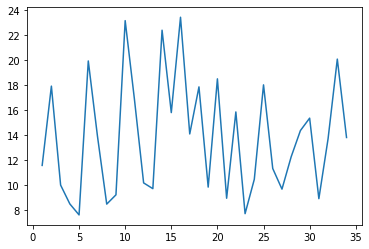

In [18]:
plt.plot([x for x in range(1, 35)], G_losses)

In [22]:
list(train_hist["G_losses"])[199]

12.217755317687988

In [25]:
util.show_train_hist(train_hist, save=True, path=root + model + 'train_hist.png') 

In [20]:
G_losses[1].__class__

float